# Recurrent neural network for Google Stock Price
### Importing the libraries

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

## Part 1 - Data Preprocessing
### Importing the training set

Here, we are specifically importing and utilizing the training set in this analysis to highlight the fact that our model will be trained solely on this data. During the training phase, our model will have no knowledge of the test set, and there will be no equivalent of the test set available during training. Essentially, it's as if the test set doesn't exist for our model during the training process.

However, once the training is completed, we will introduce the test set to assess and validate the model's performance by making predictions on future stock prices.

In [2]:
dataset_train = pd.read_csv('./data/Google_Stock_Price_Train.csv')


In [3]:
dataset_train.head()

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"


Check for missing values in each column

In [4]:
missing_values = dataset_train.isnull().sum()
print("Missing values per column:")
print(missing_values)

Missing values per column:
Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64


We don't have any missing values.

Now we define the real data input for our model (training set) by selecting the necessary column (Open) and converting them into a NumPy array, which will serve as the input data for training our model.

In [5]:
training_set = dataset_train[['Open']].values

In [6]:
training_set

array([[325.25],
       [331.27],
       [329.83],
       ...,
       [793.7 ],
       [783.33],
       [782.75]])

### Feature Scaling

Now, we are going to apply the appropriate feature scaling to our data to optimize the training process.

We have two possibilities:
- Standardization
- Normalization

I have chosen to use Normalization as it is more relevant in this context. When building an RNN, especially when a sigmoid function is used as an activation function in the output layer, it is recommended to apply normalization for improved performance.

Normalization helps in bringing all features to a similar scale, which can aid in the training process by ensuring that no particular feature dominates due to its larger scale. This is particularly important for activation functions like sigmoid, where small input values can result in vanishing gradients, impacting learning during backpropagation.

In [7]:
scaler = MinMaxScaler(feature_range=(0,1))

In [8]:
training_set_scaled = scaler.fit_transform(training_set)

In [9]:
print(training_set_scaled)

[[0.08581368]
 [0.09701243]
 [0.09433366]
 ...
 [0.95725128]
 [0.93796041]
 [0.93688146]]


### Create a specific data structure
Now, we will define a specific data structure that outlines what the RNN needs to remember when predicting the next stock price. This structure is referred to as the 'number of time steps.' It plays a critical role in determining the temporal memory or context the RNN will consider during its prediction of future stock prices.

In this case, we have 60 timesteps and one output. This implies that at each time 't,' the RNN will analyze the 60 stock prices leading up to time 't' (or the 60 days prior to time 't'), and then we will attempt to predict the subsequent output.

X_train: The input for the RNN, consisting of the 60 previous stock prices.
y_train: The output representing the stock price for the next financial day.

In [10]:
X_train = []
y_train = []

nb_timesteps = 60

for i in range(nb_timesteps, len(training_set_scaled)):
    X_train.append(training_set_scaled[i-nb_timesteps:i, 0])
    y_train.append(training_set_scaled[i,0])

X_train, y_train = np.array(X_train), np.array(y_train) 

In [11]:
print(X_train)

[[0.08581368 0.09701243 0.09433366 ... 0.07846566 0.08034452 0.08497656]
 [0.09701243 0.09433366 0.09156187 ... 0.08034452 0.08497656 0.08627874]
 [0.09433366 0.09156187 0.07984225 ... 0.08497656 0.08627874 0.08471612]
 ...
 [0.92106928 0.92438053 0.93048218 ... 0.95475854 0.95204256 0.95163331]
 [0.92438053 0.93048218 0.9299055  ... 0.95204256 0.95163331 0.95725128]
 [0.93048218 0.9299055  0.93113327 ... 0.95163331 0.95725128 0.93796041]]


In [12]:
print(y_train)

[0.08627874 0.08471612 0.07454052 ... 0.95725128 0.93796041 0.93688146]


### Reshaping 
We are now going to reshape the data structure to introduce additional dimensions to the previous data structure, allowing for the inclusion of more indicators if desired.

The input shape with Keras should be a 3D tensor with dimensions (batch_size, timesteps, input_dim) for Recurrent Layers. 'Batch_size' corresponds to the number of observations.


In [13]:
batch_size, timesteps = X_train.shape
input_dim = 1

X_train = np.reshape(X_train, (batch_size, timesteps, input_dim))

Now we have the right structure expected for our RNN.

## Part 2 - Building the RNN

We will construct a robust architecture by not only using a simple LSTM but also implementing a stacked LSTM with dropout regularization to prevent overfitting.

### Initialising the RNN
Initialising the RNN as a sequence of layer.

In [14]:
regressor = Sequential()

### Adding the first LSTM layer and some Dropout regularisation
As mentionned before, we will use some dropout regularization, but what's it ? 

This is a technique used in neural network training to prevent overfitting and improve the model's generalization performance. During the training process, dropout randomly sets a fraction (rate) of the neurons in a layer to zero, effectively 'dropping out' those units. This means that the model trains on a reduced network for each batch, as different neurons are dropped out in each training iteration.

By doing this, dropout helps prevent the neural network from relying too heavily on a specific set of neurons and encourages the network to learn more robust and generalizable features. It essentially forces the model to learn redundant representations of information, reducing the risk of overfitting to the training data.

When utilizing multiple LSTM layers, it is necessary to set 'return_sequences' to True. 'Units' represents the number of LSTM cells, memory units, or neurons that we intend to have in this initial LSTM layer.

In [15]:
regressor.add(LSTM(units=70, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(rate=0.3))

### Adding others LSTM layers with Dropout regularisation

In [16]:
# regressor.add(LSTM(units=70, return_sequences=True))
# regressor.add(Dropout(rate=0.3))

In [17]:
# regressor.add(LSTM(units=50, return_sequences=True))
# regressor.add(Dropout(rate=0.2))

In [18]:
regressor.add(LSTM(units=70))
regressor.add(Dropout(rate=0.3))

### Adding the output layer

In [19]:
regressor.add(Dense(units=1))

### Compiling the RNN

In [20]:
regressor.compile(optimizer="rmsprop", loss="mean_squared_error")

### Fitting the RNN on the training set
Epochs represent the number of times the entire dataset is used for training. With 100 epochs, the model learns from the data 100 times.

Batch size refers to the number of data samples processed in a single training iteration. A batch size of 32 means 32 samples are used to update the model's weights at each step, enhancing training efficiency

In [21]:
regressor.fit(x=X_train, y=y_train, epochs=85, batch_size=32)

Epoch 1/85
38/38 [==============================] - 4s 32ms/step - loss: 0.0252
Epoch 2/85
38/38 [==============================] - 1s 32ms/step - loss: 0.0085
Epoch 3/85
38/38 [==============================] - 1s 31ms/step - loss: 0.0068
Epoch 4/85
38/38 [==============================] - 1s 32ms/step - loss: 0.0064
Epoch 5/85
38/38 [==============================] - 1s 31ms/step - loss: 0.0061
Epoch 6/85
38/38 [==============================] - 1s 31ms/step - loss: 0.0058
Epoch 7/85
38/38 [==============================] - 1s 31ms/step - loss: 0.0055
Epoch 8/85
38/38 [==============================] - 1s 31ms/step - loss: 0.0053
Epoch 9/85
38/38 [==============================] - 1s 31ms/step - loss: 0.0050
Epoch 10/85
38/38 [==============================] - 1s 31ms/step - loss: 0.0050
Epoch 11/85
38/38 [==============================] - 1s 30ms/step - loss: 0.0052
Epoch 12/85
38/38 [==============================] - 1s 30ms/step - loss: 0.0041
Epoch 13/85
38/38 [==================

The fitting process appears to converge around the 80th epoch, suggesting that the model's performance stabilizes and further epochs may not significantly enhance performance.

## Part 3 - Making the predictions and visualising the results

### Get the real Google stock price of 2017

In [22]:
dataset_test = pd.read_csv('./data/Google_Stock_Price_Test.csv')
real_stock_price = dataset_test[['Open']].values

In [23]:
print(real_stock_price)

[[778.81]
 [788.36]
 [786.08]
 [795.26]
 [806.4 ]
 [807.86]
 [805.  ]
 [807.14]
 [807.48]
 [807.08]
 [805.81]
 [805.12]
 [806.91]
 [807.25]
 [822.3 ]
 [829.62]
 [837.81]
 [834.71]
 [814.66]
 [796.86]]


### Getting the predicted stock price of 2017

In [24]:
dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), axis=0)
dataset_total.head()

0    325.25
1    331.27
2    329.83
3    328.34
4    322.04
Name: Open, dtype: float64

At each financial day of january 2017, we need to get the previous 60 stock prices.

In [25]:
idx_first_day_january = len(dataset_total) - len(dataset_test)
inputs = dataset_total[idx_first_day_january - nb_timesteps:].values
print(inputs)

[779.   779.66 777.71 786.66 783.76 781.22 781.65 779.8  787.85 798.24
 803.3  795.   804.9  816.68 806.34 801.   808.35 795.47 782.89 778.2
 767.25 750.66 774.5  783.4  779.94 791.17 756.54 755.6  746.97 755.2
 766.92 771.37 762.61 772.63 767.73 764.26 760.   771.53 770.07 757.44
 744.59 757.71 764.73 761.   772.48 780.   785.04 793.9  797.4  797.34
 800.4  790.22 796.76 795.84 792.36 790.9  790.68 793.7  783.33 782.75
 778.81 788.36 786.08 795.26 806.4  807.86 805.   807.14 807.48 807.08
 805.81 805.12 806.91 807.25 822.3  829.62 837.81 834.71 814.66 796.86]


reshape inputs in lines and one column

In [26]:
inputs = inputs.reshape(-1,1)
print(inputs)

[[779.  ]
 [779.66]
 [777.71]
 [786.66]
 [783.76]
 [781.22]
 [781.65]
 [779.8 ]
 [787.85]
 [798.24]
 [803.3 ]
 [795.  ]
 [804.9 ]
 [816.68]
 [806.34]
 [801.  ]
 [808.35]
 [795.47]
 [782.89]
 [778.2 ]
 [767.25]
 [750.66]
 [774.5 ]
 [783.4 ]
 [779.94]
 [791.17]
 [756.54]
 [755.6 ]
 [746.97]
 [755.2 ]
 [766.92]
 [771.37]
 [762.61]
 [772.63]
 [767.73]
 [764.26]
 [760.  ]
 [771.53]
 [770.07]
 [757.44]
 [744.59]
 [757.71]
 [764.73]
 [761.  ]
 [772.48]
 [780.  ]
 [785.04]
 [793.9 ]
 [797.4 ]
 [797.34]
 [800.4 ]
 [790.22]
 [796.76]
 [795.84]
 [792.36]
 [790.9 ]
 [790.68]
 [793.7 ]
 [783.33]
 [782.75]
 [778.81]
 [788.36]
 [786.08]
 [795.26]
 [806.4 ]
 [807.86]
 [805.  ]
 [807.14]
 [807.48]
 [807.08]
 [805.81]
 [805.12]
 [806.91]
 [807.25]
 [822.3 ]
 [829.62]
 [837.81]
 [834.71]
 [814.66]
 [796.86]]


Scale only the input values

In [27]:
inputs = scaler.transform(inputs)
print(inputs)

[[0.9299055 ]
 [0.93113327]
 [0.92750577]
 [0.94415507]
 [0.93876032]
 [0.93403527]
 [0.93483518]
 [0.9313937 ]
 [0.94636878]
 [0.96569685]
 [0.97510976]
 [0.95966962]
 [0.97808617]
 [1.        ]
 [0.98076494]
 [0.97083116]
 [0.98450406]
 [0.96054394]
 [0.9371419 ]
 [0.92841729]
 [0.90804747]
 [0.8771858 ]
 [0.92153434]
 [0.93809063]
 [0.93165414]
 [0.95254483]
 [0.88812412]
 [0.88637547]
 [0.87032145]
 [0.88563137]
 [0.90743359]
 [0.91571173]
 [0.89941588]
 [0.91805566]
 [0.9089404 ]
 [0.9024853 ]
 [0.89456061]
 [0.91600938]
 [0.9132934 ]
 [0.88979835]
 [0.86589404]
 [0.89030062]
 [0.90335962]
 [0.89642086]
 [0.91777662]
 [0.93176576]
 [0.94114145]
 [0.95762334]
 [0.96413424]
 [0.96402262]
 [0.96971501]
 [0.95077759]
 [0.96294367]
 [0.96123223]
 [0.95475854]
 [0.95204256]
 [0.95163331]
 [0.95725128]
 [0.93796041]
 [0.93688146]
 [0.92955205]
 [0.94731751]
 [0.94307612]
 [0.96015329]
 [0.98087655]
 [0.98359253]
 [0.97827219]
 [0.98225314]
 [0.98288563]
 [0.98214153]
 [0.979779  ]
 [0.97

Make the special structure

In [28]:
X_test = []

for i in range(nb_timesteps, nb_timesteps+len(dataset_test)):
    X_test.append(inputs[i-nb_timesteps:i, 0])

X_test = np.array(X_test)

In [29]:
print(X_test)

[[0.9299055  0.93113327 0.92750577 ... 0.95725128 0.93796041 0.93688146]
 [0.93113327 0.92750577 0.94415507 ... 0.93796041 0.93688146 0.92955205]
 [0.92750577 0.94415507 0.93876032 ... 0.93688146 0.92955205 0.94731751]
 ...
 [0.96054394 0.9371419  0.92841729 ... 1.01045465 1.02407173 1.03930724]
 [0.9371419  0.92841729 0.90804747 ... 1.02407173 1.03930724 1.03354044]
 [0.92841729 0.90804747 0.8771858  ... 1.03930724 1.03354044 0.99624228]]


In [30]:
batch_size, timesteps = X_test.shape
input_dim = 1
X_test = np.reshape(X_test, (batch_size, timesteps, input_dim))

In [31]:
print(X_test)

[[[0.9299055 ]
  [0.93113327]
  [0.92750577]
  ...
  [0.95725128]
  [0.93796041]
  [0.93688146]]

 [[0.93113327]
  [0.92750577]
  [0.94415507]
  ...
  [0.93796041]
  [0.93688146]
  [0.92955205]]

 [[0.92750577]
  [0.94415507]
  [0.93876032]
  ...
  [0.93688146]
  [0.92955205]
  [0.94731751]]

 ...

 [[0.96054394]
  [0.9371419 ]
  [0.92841729]
  ...
  [1.01045465]
  [1.02407173]
  [1.03930724]]

 [[0.9371419 ]
  [0.92841729]
  [0.90804747]
  ...
  [1.02407173]
  [1.03930724]
  [1.03354044]]

 [[0.92841729]
  [0.90804747]
  [0.8771858 ]
  ...
  [1.03930724]
  [1.03354044]
  [0.99624228]]]


In [32]:
predicted_stock_price = regressor.predict(X_test)

1/1 [==============================] - 1s 568ms/step


In [33]:
print(predicted_stock_price)

[[0.95676154]
 [0.9513264 ]
 [0.95016074]
 [0.95007956]
 [0.9538751 ]
 [0.96261185]
 [0.97216105]
 [0.97913206]
 [0.98451245]
 [0.98830736]
 [0.99054605]
 [0.99121845]
 [0.9908413 ]
 [0.99074334]
 [0.99086726]
 [0.9965914 ]
 [1.006093  ]
 [1.0182517 ]
 [1.0279306 ]
 [1.0273386 ]]


inverse the scaling of the predicted values

In [34]:
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

In [35]:
print(predicted_stock_price)

[[793.43677]
 [790.51495]
 [789.88837]
 [789.8447 ]
 [791.88513]
 [796.58167]
 [801.71484]
 [805.4622 ]
 [808.3545 ]
 [810.3945 ]
 [811.59796]
 [811.95935]
 [811.75665]
 [811.704  ]
 [811.77057]
 [814.84766]
 [819.9553 ]
 [826.49133]
 [831.69434]
 [831.3761 ]]


### Visualising the results

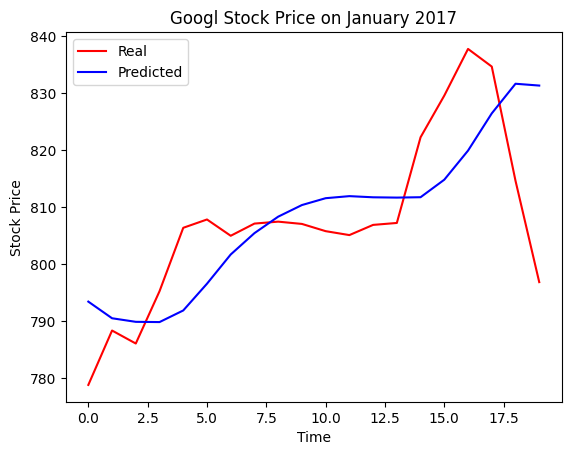

In [41]:
plt.plot(real_stock_price, color="red", label="Real")
plt.plot(predicted_stock_price, color="blue", label="Predicted")
plt.title("Googl Stock Price on January 2017")
plt.xlabel("Financial day of January 2017")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

Here, we observe a horizontal shift between predicted and actual values, suggesting a problem of temporal synchronization between them. Neural networks, including RNNs, have a certain latency or delay in their response to changes in data, hence the observed phenomenon.

Furthermore, it can be argued that the slopes of the predictions appear to be smoother than those of the actual data, indicating that the model struggles to capture the abrupt variations present in the real data. This could be due to insufficient model complexity or over-smoothing of the data, thereby reducing the model's ability to capture rapid and significant changes.

### Evaluate the model



In [45]:
y_true = real_stock_price
y_pred = predicted_stock_price

#### Residuals plots

We will start by using the residual plot. This is an essential tool in evaluating the performance of a regression model. It allows us to analyze the differences between the values predicted by the model and the actual values of the target variable. We then obtain crucial information about the quality of the model's adjustments. 

A precise model will produce residuals randomly distributed around zero, indicating that the model is not making systematic errors and has effectively captured the trends and patterns in the data. On the other hand, structures or patterns in the residuals can reveal aspects not accounted for by the model, suggesting possible improvements.

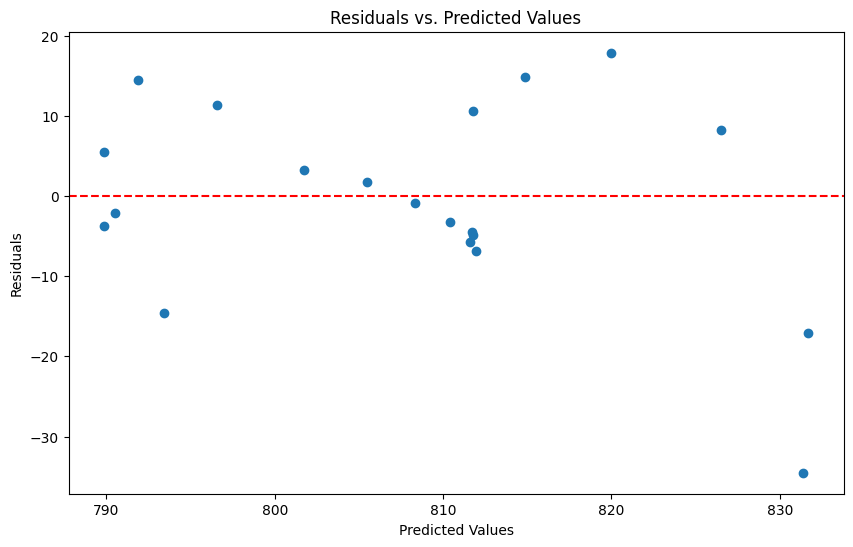

In [42]:
residuals = y_true - y_pred

plt.figure(figsize=(10, 6))
plt.scatter(predicted_stock_price, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted Values')
plt.show()

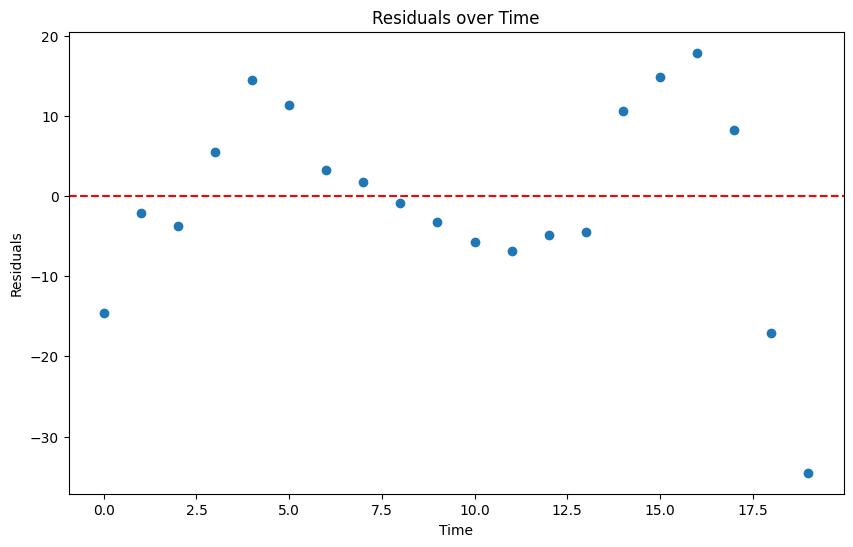

In [48]:
plt.figure(figsize=(10, 6))
time = np.arange(len(y_true)) 
plt.scatter(time, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.title('Residuals over Time')
plt.show()

#### Q-Q plot


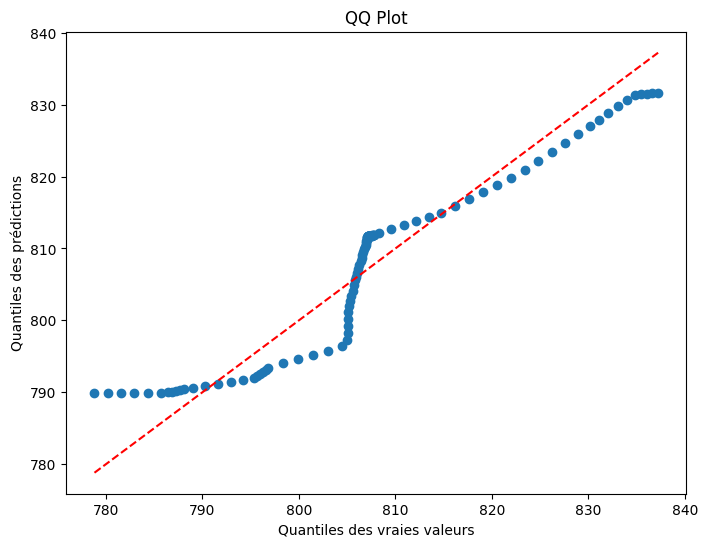

In [49]:
quantiles_pred  = np.percentile(y_pred, np.arange(0, 100, 1))
quantiles_true = np.percentile(y_true, np.arange(0, 100, 1))

plt.figure(figsize=(8, 6))
plt.scatter(quantiles_true, quantiles_pred)
plt.xlabel('Quantiles des vraies valeurs')
plt.ylabel('Quantiles des prédictions')
plt.title('QQ Plot')
plt.plot([np.min(quantiles_true), np.max(quantiles_true)], [np.min(quantiles_true), np.max(quantiles_true)], color='red', linestyle='--')
plt.show()

#### R-squared (R²)

In [47]:
r_squared = r2_score(y_true, y_pred)
print("R-quared (R²) :", r_squared)

R-quared (R²) : 0.322209097264993


An R² of 0.322 means that the model is able to explain approximately 32.2% of the total observed variation in the data. This indicates that the model partially captures patterns and trends in the data, but there is still a significant portion of variability not accounted for. A higher R², closer to 1, would be desirable for a better explanation of the variance in the data by the model.

### Conclusion
To enhance the obtained results, it would be prudent to incorporate additional indicators, use a more complex model, optimize the hyperparameters, better manage overfitting, gather more data, and estimate trends using a larger dataset beyond the 60-value timesteps.